In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
from PIL import Image
from PIL import UnidentifiedImageError
from skimage import color
from sklearn.model_selection import train_test_split

In [113]:
class Incidents12(datasets.VisionDataset):
    def __init__(
        self,
        root: str,
        train = True,
        transform = None,
        ):
        
            super().__init__(root, transform=transform)
            
            self.train = train
            self.data = []
            self.targets = []
            self.errors = []

            classes = os.listdir(root)
            self.classes = classes[1:]
            paths = [root + self.classes[i] + '/' for i in range(len(self.classes))]

            for p in paths:
                for path, dirs, files in os.walk(p):
                    for filename in files:
                        try:
                            im = Image.open(p + filename).convert('RGB')
                            self.data.append(im)
                            self.targets.append(paths.index(p))
                        except UnidentifiedImageError:
                            self.errors.append(p + filename)
            
            X_train, X_test, y_train, y_test = train_test_split(self.data, self.targets, random_state=42)
            
            if self.train:
                self.data = X_train
                self.targets = y_train
            else:
                self.data = X_test
                self.targets = y_test
            
            #self.data = np.vstack(self.data).reshape(-1, 3, 256, 256)
            # self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
            
    def __getitem__(self, index: int): 
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)
            img = img.numpy().transpose((1,2,0))

        return img, target
    
    def __len__(self):
        return(len(self.data))

    def to_dataframe(self):
        tensor_images = [self[i][0] for i in range(len(self.data))]
        return(pd.DataFrame(data={"Image": tensor_images, "Label": self.targets}))

In [104]:
transform = transforms.Compose([
    # center-crop
    transforms.CenterCrop(224),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.04544269, 0.04544269, 0.04544269], [0.21317291, 0.21317291, 0.21317291])
])

In [105]:
train_set = Incidents12("datasets/incidents/", train=True, transform=transform)
test_set = Incidents12("datasets/incidents/", train=False, transform=transform)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [107]:
def imshow(inp, title=None):
    mean = np.array([0.04544269, 0.04544269, 0.04544269])
    std = np.array([0.21317291, 0.21317291, 0.21317291])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

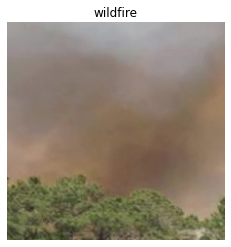

In [110]:
import random
r = random.randint(0,len(dataset.data))
imshow(dataset[r][0], dataset.classes[dataset[r][1]])

In [ ]:
df = dataset.to_dataframe()
df

,Image,Label
0,"[[[2.0127656, 0.5042784, -0.17638053], [2.0311...",3
1,"[[[4.3122888, 2.141539, 2.435878], [4.3674774,...",6
2,"[[[3.1533291, 3.1533291, 3.1533291], [3.833988...",11
3,"[[[0.26512796, 1.148145, 0.007581335], [0.2835...",11
4,"[[[3.6684225, 3.7604034, 3.8339882], [3.650026...",2
...,...,...
1835,"[[[1.8471999, 1.8288038, 1.9207847], [1.240125...",11
1836,"[[[2.2703123, 1.4056915, -0.21317291], [2.3255...",3
1837,"[[[2.748613, 2.748613, 2.748613], [2.748613, 2...",9
1838,"[[[0.06276989, 0.06276989, 0.06276989], [0.191...",1


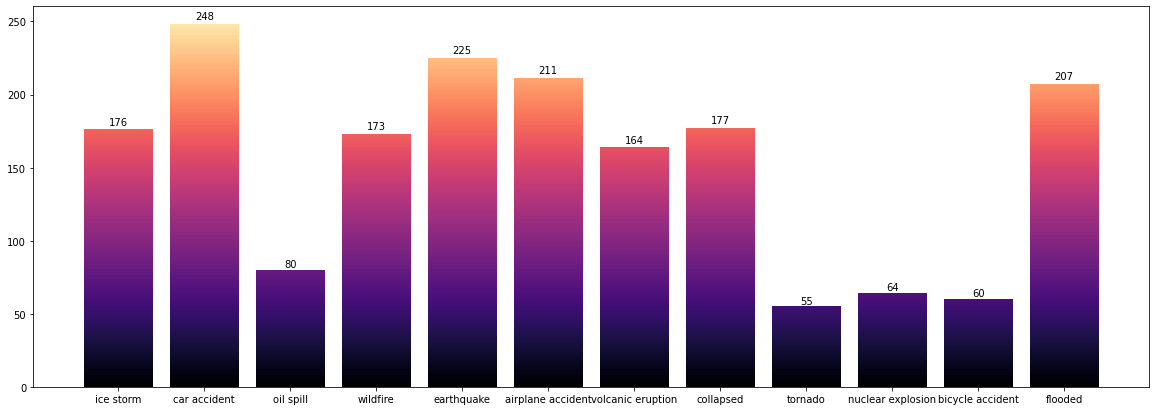

In [114]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
rects = plt.bar(dataset.classes,df["Label"].value_counts().sort_index())

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, '%d'%int(height),
                ha='center', va='bottom')
        
autolabel(rects)

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin=ymin, vmax=ymax, cmap='magma')
    ax.axis([xmin, xmax, ymin, ymax])

gradientbars_sliced(rects)
plt.show()

In [117]:
class_counts = df["Label"].value_counts()
samples_class = [df[df["Label"] == i] for i in range(len(dataset.classes))]

In [120]:
classes_under = [samples_class[i].sample(df[df["Label"] == dataset.classes.index("tornado")].shape[0]) for i in range(len(dataset.classes))]
new_df = pd.concat(classes_under,axis=0).reset_index()

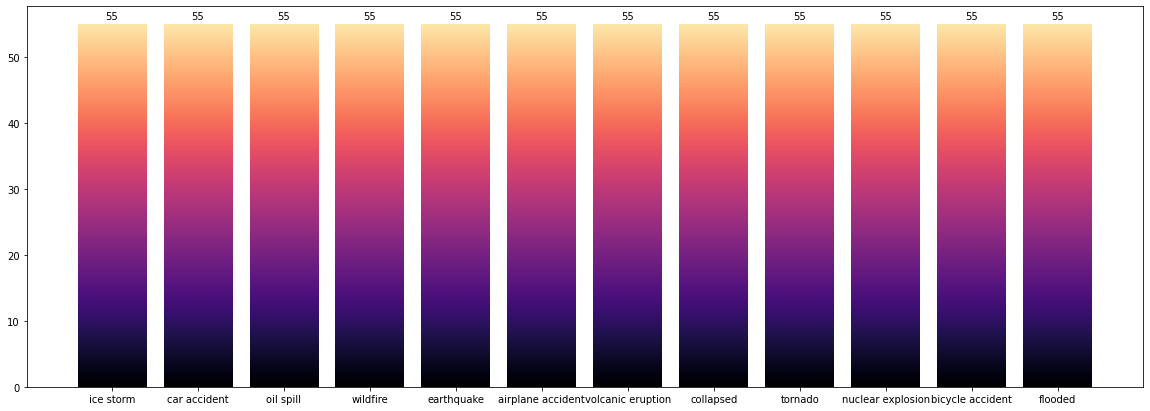

In [121]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
rects = plt.bar(dataset.classes, new_df["Label"].value_counts().sort_index())
autolabel(rects)
gradientbars_sliced(rects)
plt.show()

-> Program resampling in Incidents12 class

 ### Neural network